In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Conv2D, UpSampling2D, Reshape,Input
import tensorflow.keras.backend as K
from tensorflow.keras.layers import concatenate

In [11]:
vgg19_cl = keras.applications.VGG19()
vgg19_cl.trainable = False
vgg19_cl.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
inp_for_vgg = Input((224,224,3))
vgg19 = keras.applications.VGG19(include_top=False,input_shape=(224,224,3),weights="imagenet",)(inp_for_vgg)
vgg19.trainable = False
# print(vgg19.summary())
out_vgg19 = Conv2D(512, (3, 3), activation='relu', padding='same')(vgg19)

vgg19_ph = keras.Model(inp_for_vgg,out_vgg19)
vgg19_ph.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
Total params: 22,384,192
Trainable params: 22,384,192
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_out = keras.Sequential()
model_out.add(Input((7, 7, 533)))
model_out.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_out.add(UpSampling2D((2, 2))) # 14 14 512
model_out.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_out.add(UpSampling2D((2, 2)))  # 28 28 256
model_out.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_out.add(UpSampling2D((2, 2))) # 56 56 128
model_out.add(Conv2D(64, (3, 3), activation='tanh', padding='same'))
model_out.add(UpSampling2D((2, 2))) # 112 112 64
model_out.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
model_out.add(UpSampling2D((2, 2))) # 224 224 32
model_out.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
model_out.add(Conv2D(1, (3, 3), activation='tanh', padding='same'))
model_out.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 7, 7, 512)         2456576   
                                                                 
 up_sampling2d_5 (UpSampling  (None, 14, 14, 512)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 256)       1179904   
                                                                 
 up_sampling2d_6 (UpSampling  (None, 28, 28, 256)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 128)       295040    
                                                                 
 up_sampling2d_7 (UpSampling  (None, 56, 56, 128)     

In [14]:
# batch = 100
inp = Input((224, 224, 1),1)
inp_3d = Reshape((224,224,3))(concatenate([inp,inp,inp])) # 224 224 3

out_vgg19_cl = vgg19_cl(inp_3d) # 1000 output for class
out_vgg19_ph = vgg19_ph(inp_3d) # 7 7 512


cont_cl_zeros = concatenate([
    out_vgg19_cl,
    K.constant([[0 for _ in range(29)]for _ in range(out_vgg19_cl.shape[0])],dtype=tf.float32)
])
cont_cl_zeros_re = Reshape((7,7,21))(cont_cl_zeros)

concatenate_vgg_ph_cl = concatenate([
    out_vgg19_ph,
    cont_cl_zeros_re
]) # 7 7 533

output_model = model_out(concatenate_vgg_ph_cl)

model = keras.Model(inp,output_model)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(1, 224, 224, 1)]   0           []                               
                                                                                                  
 concatenate_3 (Concatenate)    (1, 224, 224, 3)     0           ['input_11[0][0]',               
                                                                  'input_11[0][0]',               
                                                                  'input_11[0][0]']               
                                                                                                  
 reshape_2 (Reshape)            (1, 224, 224, 3)     0           ['concatenate_3[0][0]']          
                                                                                            

In [15]:
import data_preparation as dp
# x,ab,y = dp.create_data_imagenet()
# y.shape = (1,224,224,3)
# # y = y / 255
x,y = dp.avg_photo()

In [18]:
model.compile(optimizer="adam",
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.fit(x,x,epochs=50)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 490.3357 - accuracy: 0.6648
Epoch 2/50
1/1 [==============================] - 1s 863ms/step - loss: 490.9167 - accuracy: 0.5559
Epoch 3/50
1/1 [==============================] - 1s 817ms/step - loss: 490.5858 - accuracy: 0.6643
Epoch 4/50
1/1 [==============================] - 1s 823ms/step - loss: 498.6182 - accuracy: 0.6666
Epoch 5/50
1/1 [==============================] - 1s 788ms/step - loss: 490.9228 - accuracy: 0.6645
Epoch 6/50
1/1 [==============================] - 1s 769ms/step - loss: 490.7393 - accuracy: 0.6635
Epoch 7/50
1/1 [==============================] - 1s 779ms/step - loss: 490.8530 - accuracy: 0.5150
Epoch 8/50
1/1 [==============================] - 1s 758ms/step - loss: 490.9033 - accuracy: 0.0225
Epoch 9/50
1/1 [==============================] - 1s 791ms/step - loss: 490.9212 - accuracy: 0.0206
Epoch 10/50
1/1 [==============================] - 1s 833ms/step - loss: 490.9095 - accuracy: 0.0192
Ep

1/1 [==============================] - 1s 524ms/step


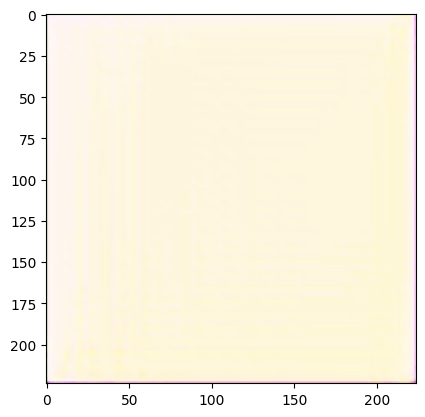

In [17]:
a = model.predict(x)
# k = dp.lab_ab_in_rgb(x,a)

plt.imshow(np.squeeze(a))
